In [18]:
import numpy as np
import matplotlib.pyplot as plt

class Neural_Network:
    def __init__(self, InputSize=784, HiddenLayers=[512, 512], OutputSize=10):
        self.InputSize=InputSize
        self.HiddenLayers=HiddenLayers
        self.OutputSize=OutputSize
        self.weights=[]
        self.bias=[]
        self.values=[]
        self.z_values=[]

    def RandomiseNetwork(self):
        #generating weights for input to hidden layers
        self.weights.append(np.random.randn(self.InputSize, self.HiddenLayers[0]) * np.sqrt(1 / self.InputSize))
        self.bias.append(np.zeros((1, self.HiddenLayers[0])))

        #generating weights for all hidden layers
        for x in range(len(self.HiddenLayers) - 1):
            self.weights.append(np.random.randn(self.HiddenLayers[x], self.HiddenLayers[x+1]) * np.sqrt(1 / self.HiddenLayers[x]))
            self.bias.append(np.zeros((1, self.HiddenLayers[x+1])))

        #generating weights for hidden layers to output
        self.weights.append(np.random.randn(self.HiddenLayers[-1], self.OutputSize) * np.sqrt(1 / self.HiddenLayers[-1]))
        self.bias.append(np.zeros((1, self.OutputSize)))
    
    #Derivative of the Sigmoid Activation Function
    def ReLUDer(self, x):
        return (x > 0).astype(float)
    
    #Sigmoid Activation Function 
    def ReLU(self, x):
        return np.maximum(0, x)
    
    #Softmax Activation function applied at output
    def SoftMaxActivation(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        
    #Produces a probability distribution of the softmax output, showcasing reasoning of the network
    def ShowProbabiiltyPlot(self, output):
        numbers = np.arange(10)
        plt.figure(figsize=(8, 4))
        plt.bar(numbers, output[0], color='skyblue', edgecolor='black')
        plt.xlabel('Number')
        plt.ylabel('Probability')
        plt.title('Probability Distribution of Numbers 0 to 9')
        plt.xticks(numbers)
        plt.show()
    
    #Produces all activations for the randomised network, and then adjusted network
    def ForwardPass(self, inputs):
        self.values = [inputs]
        self.z_values = []

        for x in range(len(self.weights)):
            z=np.dot(self.values[-1], self.weights[x]) + self.bias[x] # linear algebra can recursively perform all necessary calculations
            self.z_values.append(z)

            # at the end you don't want to apply ReLU, and instead apply the softmax activation function
            if x == len(self.weights) - 1:
                a = self.SoftMaxActivation(z)
            else:
                a = self.ReLU(z)
            
            self.values.append(a)

        self.values=self.values
        return self.values[-1]
    
    #Adjusts the network as required, the bases of the neural network is backpropagation
    def BackwardsPropagation(self, y, output):

        change_weights = []
        change_bias = []

        delta = output - y #Using Matt Mazur's https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/ formulas
        for x in reversed(range(len(self.weights))):

            previous_activations = self.values[x].reshape(1, -1)

            # linear algebra again to calculate necessary delta values of weights
            # and bias that affect the cost at the end
            del_weights = np.dot(previous_activations.T, delta)
            del_bias = np.sum(delta, axis=0, keepdims=True)

            # insert instead of append because insert puts it in the front of the list
            # we are looping backwards through the network and this adjusts for that
            change_weights.insert(0, del_weights)
            change_bias.insert(0, del_bias)

            # if we're still looping through the network, set
            # new values of delta based on what layer we're on
            if x > 0:
                previous_z_values = self.z_values[x - 1]
                delta = np.dot(delta, self.weights[x].T) * self.ReLUDer(previous_z_values)

        return change_weights, change_bias
        
    def UpdateNetwork(self, change_weights, change_bias, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * change_weights[i]
            self.bias[i] -= learning_rate * change_bias[i]

    def DetermineCategoricalCrossEntropy(self, output, label):
        numbers = np.eye(10)[label]
        return -np.sum(numbers * np.log(output + 1e-9))

    def IdentifyNum(self, output):
        return np.argmax(output)


In [19]:
gerald = Neural_Network()
gerald.RandomiseNetwork()

# loading the MNIST_Train csv every time you run the code is a bit 
# tedious and requires a lot of processing time.
# instead we'll save the file as a .npy and access it within milliseconds 
# with numpy's fast loading functions

# run the follolwing code once
# data = np.loadtxt('./train.csv', delimiter=',', skiprows=1, dtype=np.uint8)
# np.save('mnist_train.npy', data)

# use this after theres a mnist_train.npy in your files
data = np.load('./mnist_train.npy')

# seperate the label and image data
labels = data[:, 0]
images = data[:, 1:]

In [20]:
# training variables
batch_size = 16
batches = 2000

# randomise the images from the data set using permutations
perm = np.random.permutation(len(images))
images = images[perm]
labels = labels[perm]

# for the graph of loss over time
losses = []

for indent in range(batches):

    weight_grads = [np.zeros_like(w) for w in gerald.weights]
    bias_grads = [np.zeros_like(b) for b in gerald.bias]

    for i in range(batch_size):
        idx = indent * batch_size + i
        input_values = images[idx] / 255.0
        y = np.eye(10)[labels[idx]].reshape(1, 10)
        
        output = gerald.ForwardPass(input_values)

        grad_w, grad_b = gerald.BackwardsPropagation(y, output)

        for l in range(len(gerald.weights)):
            weight_grads[l] += grad_w[l]
            bias_grads[l] += grad_b[l]

    # find the mean average of all the gradients calculated
    # so that we can add them at the end of the batch
    for l in range(len(gerald.weights)):
        weight_grads[l] /= batch_size
        bias_grads[l] /= batch_size

    # update weights and bias from the gradients calculated
    gerald.UpdateNetwork(weight_grads, bias_grads, 0.1)

    # produce the losses array
    loss = gerald.DetermineCategoricalCrossEntropy(gerald.ForwardPass(images[batch_size * indent] / 255.0), labels[batch_size * indent])
    losses.append(loss)

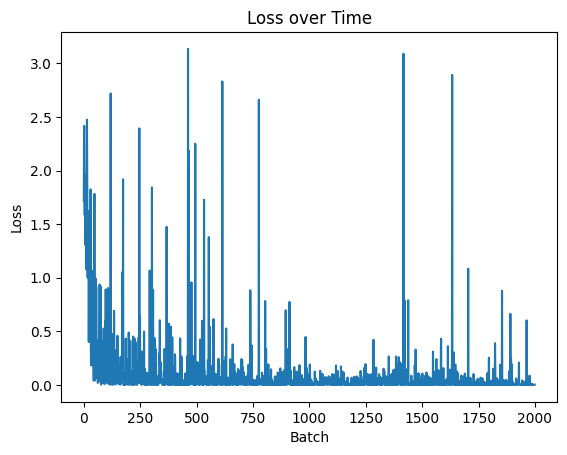

In [21]:
# show the loss of the network over the batch
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss over Time")
plt.show()

In [27]:
# this section tests the accuracy of the network
counter = 0 
test_size = 1000

perm = np.random.permutation(len(images))
images = images[perm]
labels = labels[perm]

for i in range(test_size):
    input_values = images[i] / 255.0 
    y = np.eye(10)[labels[i]].reshape(1, 10)
    output = gerald.ForwardPass(input_values)

    if np.argmax(y) == gerald.IdentifyNum(output):
        counter += 1
    
    #
    # to see which images the network got wrong, uncomment the following:
    #
    # else:
    #     plt.figure(figsize=(2, 2))
    #     plt.imshow(input_values.reshape(28, 28), cmap='gray', interpolation='none')
    #     plt.axis('off')
    #     plt.show()
    #     gerald.ShowProbabiiltyPlot(output)

print(f'Net Accuracy: {(counter/test_size) * 100:.2f}%')


Net Accuracy: 96.60%
